# DETR - Detection Transformer
Reference: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb


Original DETR paper: https://arxiv.org/abs/2005.12872

Original DETR repo: https://github.com/facebookresearch/detr


In [202]:
!python --version

Python 3.9.10


In [204]:
# !python -m pip install --upgrade pip

# !pip install supervision==0.3.0

# !pip install transformers

# !pip install pytorch-lightning

# !pip install timm

# !pip install cython

# !pip install pycocotools

# !pip install scipy

In [203]:
!pip --version

pip 23.2 from D:\transformer_detr_env\myvenv\lib\site-packages\pip (python 3.9)



In [1]:
import torch
torch.__version__

'1.13.1+cu117'

In [2]:
import supervision
import transformers

supervision.__version__ , transformers.__version__

('0.3.0', '4.31.0')

In [3]:
import pytorch_lightning
print(pytorch_lightning.__version__)

2.0.5


## Create COCO data loaders

### About dataset:

#### number of classes - 4  ['angle', 'fracture', 'line', 'messed_up_angle'


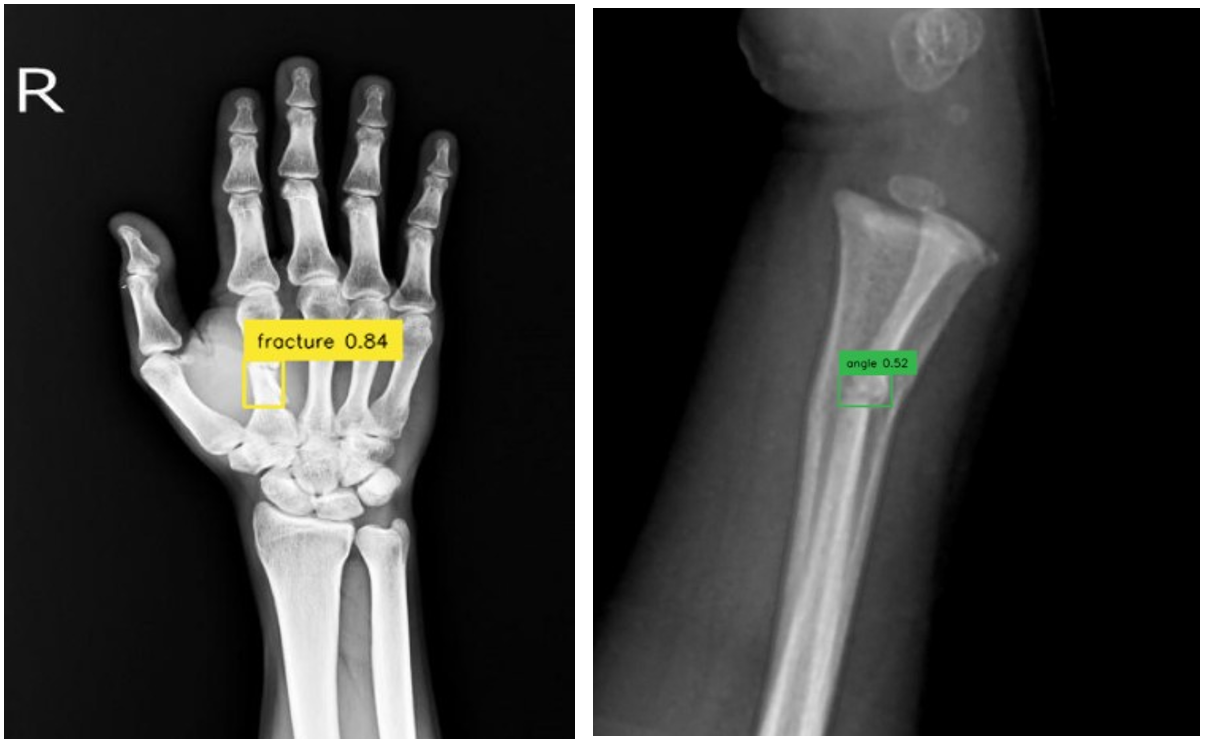]

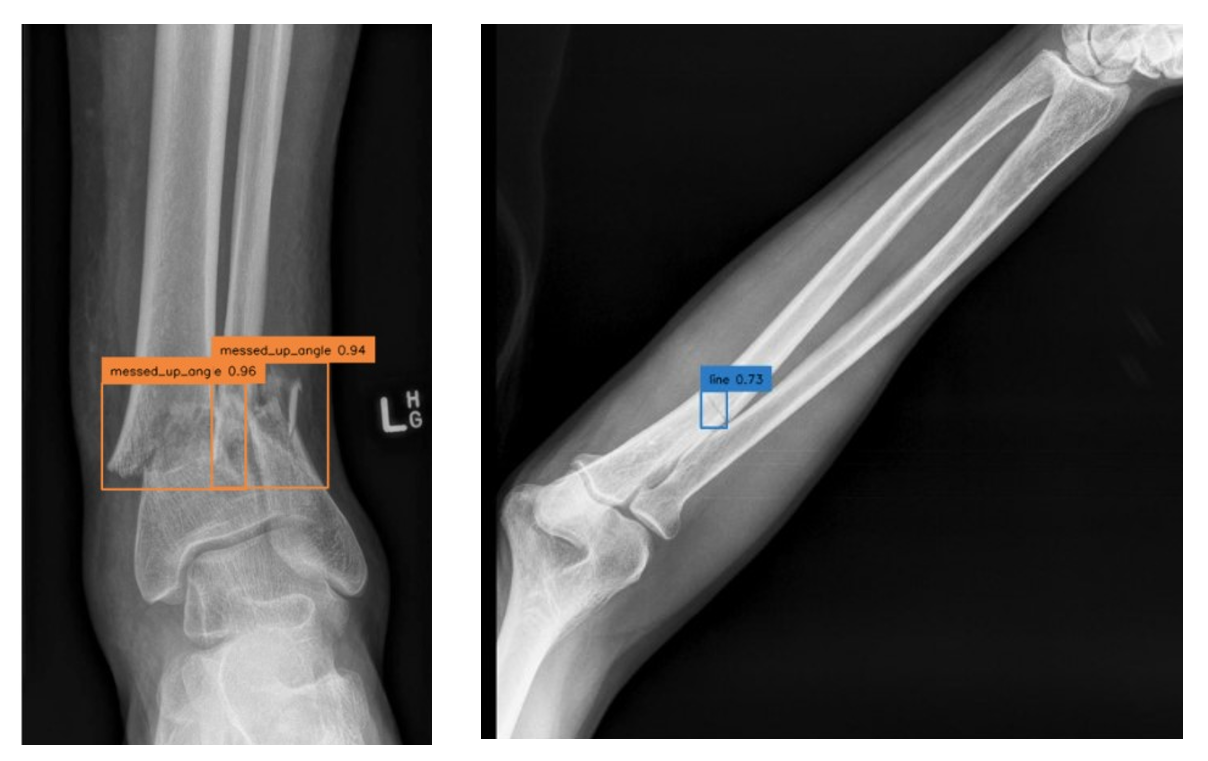

In [6]:
import os
import torchvision

dataset = 'D:/transformer_detr_env/bone_fracture_coco'

ANNOTATION_FILE_NAME = "annotations.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "val")
TEST_DIRECTORY = os.path.join(dataset, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 326
Number of validation examples: 88
Number of test examples: 44


Image #235


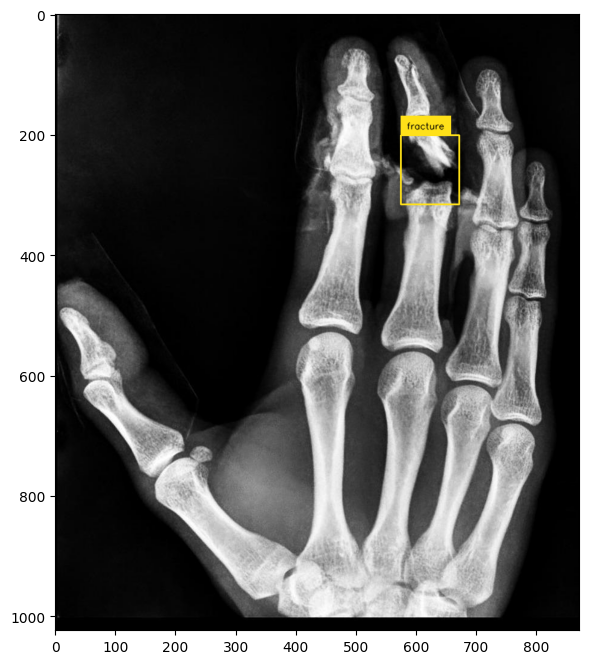

In [201]:
# Visualize if dataset is loaded properly

import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (8, 8))

In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

# Train model with PyTorch Lightning

The DETR model is loaded using the Hugging Face Transformers library

In [10]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [11]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 200

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\transformer_detr_env\myvenv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/g

Sanity Checking: 0it [00:00, ?it/s]

D:\transformer_detr_env\myvenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\transformer_detr_env\myvenv\lib\site-packages\pytorch_lightning\utilities\data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
D:\transformer_detr_env\myvenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cp

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


# Save and load model

In [14]:

MODEL_PATH = 'custom-model'
model.model.save_pretrained(MODEL_PATH)

# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

# Inference on test dataset

Let's visualize the predictions of DETR on the first image of the validation set.

Image #23


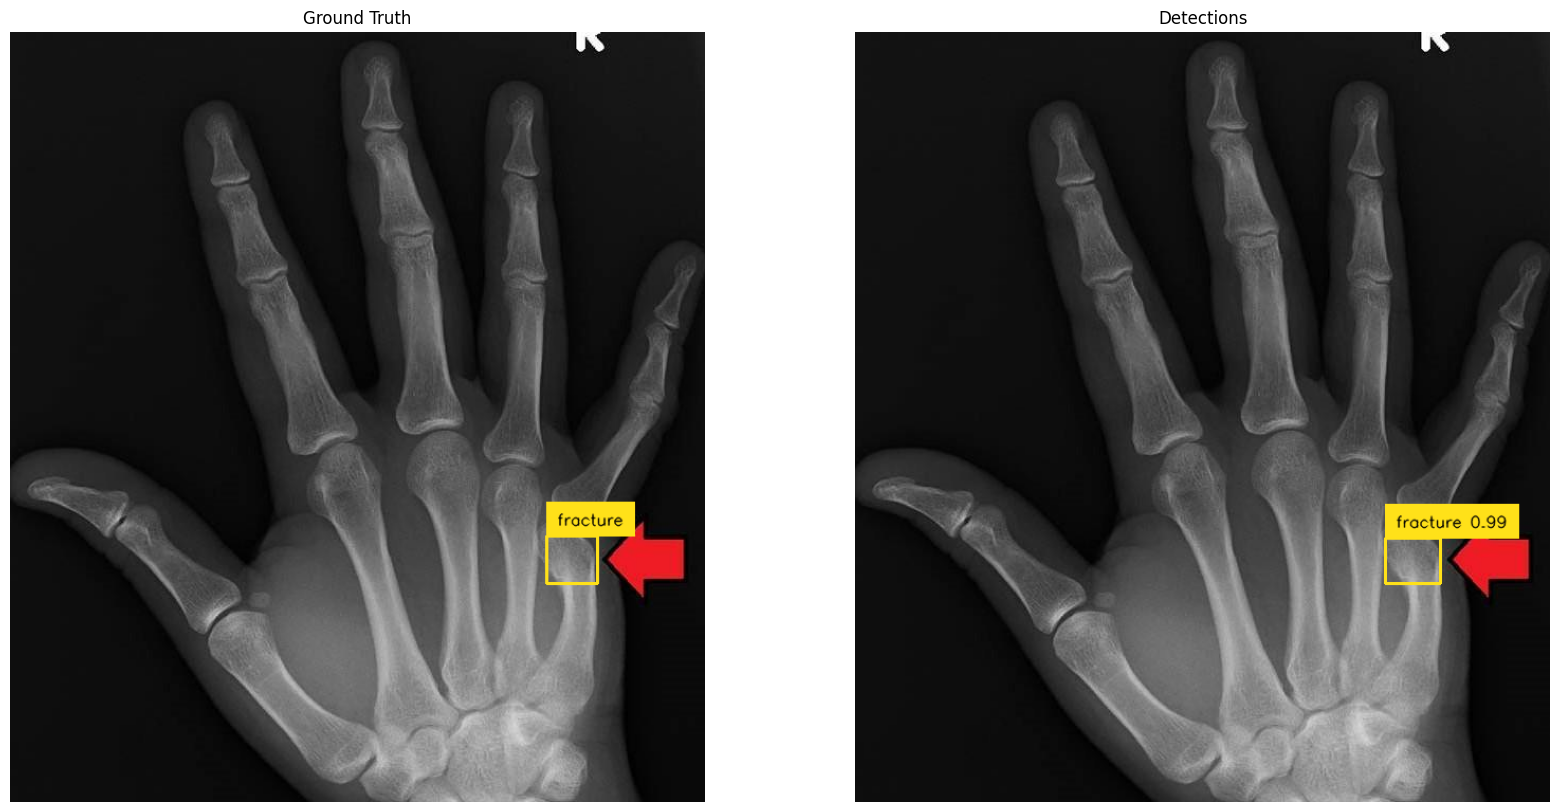

In [121]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)




# Annotate detections
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]


    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


# %matplotlib inline # Remove this line, we won't use it anymore

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()
